In [1]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd
# Tickers list
# We can add and delete any ticker from the list to get desired ticker live data
ticker_list=['^BSESN']
today = date.today()
# We can get data by our choice by giving days bracket
start_date= '2015-01-01'
files=[]
def getData(ticker):
    print (ticker)
    data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
    dataname= ticker+'_'+str(today)
    files.append(dataname)
    SaveData(data, dataname)
# Create a data folder in your current dir.
def SaveData(df, filename):
    df.to_csv('./data/'+filename+'.csv')
    #This loop will iterate over ticker list, will pass one ticker to get data,
    #and save that data as file.
for tik in ticker_list:
    getData(tik)
for i in range(0,len(ticker_list)):
    df1= pd.read_csv('./data/'+ str(files[i])+'.csv')
    print(df1.head(10))

^BSESN
[*********************100%***********************]  1 of 1 completed
         Date          Open          High           Low         Close  \
0  2015-01-02  27521.279297  27937.470703  27519.259766  27887.900391   
1  2015-01-05  27978.429688  28064.490234  27786.849609  27842.320312   
2  2015-01-06  27694.230469  27698.929688  26937.060547  26987.460938   
3  2015-01-07  26983.429688  27051.599609  26776.119141  26908.820312   
4  2015-01-08  27178.769531  27316.410156  27101.939453  27274.710938   
5  2015-01-09  27404.189453  27507.669922  27119.630859  27458.380859   
6  2015-01-12  27523.859375  27620.660156  27323.740234  27585.269531   
7  2015-01-13  27611.560547  27670.189453  27324.580078  27425.730469   
8  2015-01-14  27432.140625  27512.800781  27203.250000  27346.820312   
9  2015-01-15  27831.160156  28194.609375  27703.699219  28075.550781   

      Adj Close  Volume  
0  27887.900391    7400  
1  27842.320312    9200  
2  26987.460938   14100  
3  26908.820312 

In [3]:
df2=df1.reset_index()['Close']
print(df2.head(10))

0    27887.900391
1    27842.320312
2    26987.460938
3    26908.820312
4    27274.710938
5    27458.380859
6    27585.269531
7    27425.730469
8    27346.820312
9    28075.550781
Name: Close, dtype: float64


In [5]:
df2.shape

(1429,)

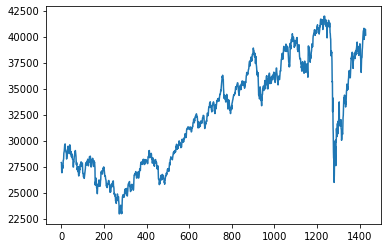

In [6]:
import matplotlib.pyplot as plt
plt.plot(df2)

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))
print(df2)

[[0.25978225]
 [0.2573834 ]
 [0.21239269]
 ...
 [0.92662726]
 [0.93331181]
 [0.90489195]]


In [8]:
##splitting dataset into train and test split
training_size=int(len(df2)*0.7)
test_size=len(df2)-training_size
train_data,test_data=df2[0:training_size,:],df2[training_size:len(df2),:1]
training_size,test_size

(1000, 429)

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

(899, 100)
(899,)
(328, 100)
(328,)


(None, None)

In [15]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [16]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 120ms/step - loss: 0.0488 - val_loss: 0.0790
Epoch 2/100
15/15 [==============================] - 0s 31ms/step - loss: 0.0100 - val_loss: 0.0150
Epoch 3/100
15/15 [==============================] - 0s 31ms/step - loss: 0.0028 - val_loss: 0.0111
Epoch 4/100
15/15 [==============================] - 0s 32ms/step - loss: 0.0016 - val_loss: 0.0104
Epoch 5/100
15/15 [==============================] - 0s 32ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 6/100
15/15 [==============================] - 0s 30ms/step - loss: 0.0014 - val_loss: 0.0099
Epoch 7/100
15/15 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0100
Epoch 8/100
15/15 [==============================] - 1s 36ms/step - loss: 0.0013 - val_loss: 0.0099
Epoch 9/100
15/15 [==============================] - 0s 31ms/step - loss: 0.0015 - val_loss: 0.0095
Epoch 10/100
15/15 [==============================] - 0s 33ms/step - loss: 0.0014 - val_loss: 0.009

In [18]:
import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [19]:
##Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [20]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

30450.226880236696

In [21]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

37215.64181938003

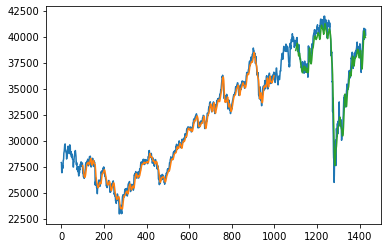

In [24]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [26]:
len(test_data)

429

In [28]:
x_input=test_data[329:].reshape(1,-1)
x_input.shape

(1, 100)

In [29]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.6009614727341337,
 0.5791788770394009,
 0.5944603069217176,
 0.5571629441155281,
 0.5699265933412134,
 0.5408704547680923,
 0.5606810938972653,
 0.5555604210308183,
 0.5924077616391334,
 0.619968691694603,
 0.6294203913507337,
 0.6567407887559005,
 0.6271920722083129,
 0.6257774524076856,
 0.6431013539829586,
 0.6320623444182909,
 0.6296561955814153,
 0.6558997468136878,
 0.6784909022636694,
 0.687844333025061,
 0.7123622166790069,
 0.7222164487533369,
 0.7040325915573658,
 0.7255411444975228,
 0.7179960258661,
 0.723225452383838,
 0.6884567661577552,
 0.6894435667743821,
 0.7115411163325884,
 0.7404062678697001,
 0.7613973672365133,
 0.7883088591361651,
 0.7852138001188067,
 0.7993684270470127,
 0.798759488833169,
 0.7885405516976107,
 0.8179192507222917,
 0.7957191150166487,
 0.7780851935809854,
 0.7712865484993487,
 0.7361675480543632,
 0.7755505550804864,
 0.7742568183553962,
 0.793315022014391,
 0.7941108355950086,
 0.8015583020820776,
 0.8133964145627512,
 0.8114289808333512,


In [34]:
# demonstrate prediction for next 30 days
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i+1,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

1 day output [[0.4815373]]
2 day output [[0.4802212]]
3 day output [[0.47890967]]
4 day output [[0.4776025]]
5 day output [[0.47629967]]
6 day output [[0.4750011]]
7 day output [[0.4737066]]
8 day output [[0.47241622]]
9 day output [[0.47112983]]
10 day output [[0.46984738]]
11 day output [[0.46856874]]
12 day output [[0.46729386]]
13 day output [[0.46602267]]
14 day output [[0.46475512]]
15 day output [[0.46349108]]
16 day output [[0.46223056]]
17 day output [[0.46097347]]
18 day output [[0.45971966]]
19 day output [[0.4584692]]
20 day output [[0.45722198]]
21 day output [[0.45597786]]
22 day output [[0.4547369]]
23 day output [[0.453499]]
24 day output [[0.45226413]]
25 day output [[0.4510321]]
26 day output [[0.44980305]]
27 day output [[0.4485768]]
28 day output [[0.44735336]]
29 day output [[0.4461327]]
30 day output [[0.44491464]]


In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [37]:
len(df2)

1429

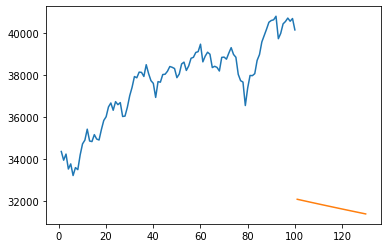

In [39]:
plt.plot(day_new,scaler.inverse_transform(df2[1329:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

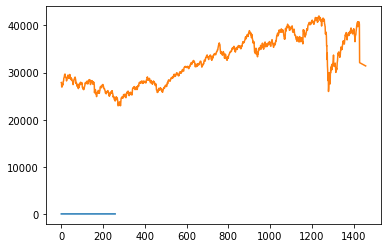

In [41]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)